In [1]:
%matplotlib inline
import contextlib
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

from classy import Class

In [2]:
# Generate k array
k_min, k_max = 1e-3, 1e+0
k_gridsize = 500
@contextlib.contextmanager
def disable_numpy_summarization():
    threshold = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=np.inf)
    try:
        yield
    finally:
        np.set_printoptions(threshold=threshold)
k = np.logspace(np.log10((1 - 1e-2)*k_min), np.log10((1 + 1e-2)*k_max), k_gridsize)
with disable_numpy_summarization():
    k_str = np.array2string(k, max_line_width=np.inf,
        formatter={'float': lambda k: f'{k:.3e}'
            .replace('+0', '+').replace('-0', '-').replace('e+0', '')},
        separator=',',
    ).strip('[]')
k = np.fromstring(k_str, sep=',')


In [3]:
# Run CLASS
models = {}

models['ref'] = {
    'output': 'dTk',
    'k_output_values': k_str,
    'omega_cdm':0.12038,
}

models['n=-4'] = {
    'output': 'dTk',
    'k_output_values': k_str,
    'omega_cdm':0.12038,
    'f_bidm':0.99,
    'm_bidm':1,
    'bidm_type':'powerlaw',
    'n_bidm':-4,
    'a_bidm':5e-4,
    'A_bidm':1.7e-41,
    'tight_coupling_trigger_tau_c_over_tau_h':0.008,
    'tight_coupling_trigger_tau_c_over_tau_k':0.001,
}

models['n=-2'] = {
    'output': 'dTk',
    'k_output_values': k_str,
    'omega_cdm':0.12038,
    'f_bidm':0.99,
    'm_bidm':1,
    'bidm_type':'powerlaw',
    'n_bidm':-2,
    'a_bidm':5e-4,
    'A_bidm':2.3e-33,
    'tight_coupling_trigger_tau_c_over_tau_h':0.008,
    'tight_coupling_trigger_tau_c_over_tau_k':0.001,
}


In [4]:
cosmo = {}
for M in models:
    cosmo[M] = Class()
    cosmo[M].set(models[M])
    cosmo[M].compute()

In [5]:
# Get and cleanup background
bg = {}
for M in models:
    bg[M] = cosmo[M].get_background()
    bg[M]['a'] = 1/(1 + bg[M]['z'])
    indices = np.unique(bg[M]['a'], return_index=True)[1]
    for key, val in bg[M].items():
        bg[M][key] = val[indices]

In [6]:
# Get and cleanup perturbations
pts = {}
for M in models:
    pts[M] = cosmo[M].get_perturbations()['scalar']
    for pt in pts[M]:
        indices = np.unique(pt['a'], return_index=True)[1]
        for key, val in pt.items():
            pt[key] = val[indices]

In [7]:
# Primordial curvature perturbation
A_s = {}
n_s = {}
alpha_s = {}
k_pivot = 0.05  # 1/Mpc
for M in models:
    derives_parameters = cosmo[M].get_current_derived_parameters(['A_s', 'n_s', 'alpha_s'])
    A_s[M] = derives_parameters['A_s']
    n_s[M] = derives_parameters['n_s']
    alpha_s[M] = derives_parameters['alpha_s']
def zeta(k,M):
    val = np.pi*np.sqrt(2*A_s[M])*k**(-3/2)*(k/k_pivot)**((n_s[M] - 1)/2)*np.exp(alpha_s[M]/4*np.log(k/k_pivot)**2)
    return val

In [8]:
# Get power spectrum
def get_Pk(a, M, species='b+cdm'):
    P = []
    for i, pt in enumerate(pts[M]):
        a_pt = pt['a']
        # Get rho at this a
        rho = {}
        for s in species.split('+'):
            rho_interp = scipy.interpolate.interp1d(
                np.log(bg[M]['a']), np.log(bg[M][f'(.)rho_{s}']), kind='cubic')
            rho[s] = lambda a, rho_interp=rho_interp: np.exp(rho_interp(np.log(a)))
        rho_a_pt = {}
        for s in species.split('+'):
            rho_a_pt[s] = rho[s](a_pt)
        # Compute weighted delta
        deltarho_combined = 0
        rho_combined = 0
        for s in species.split('+'):
            deltarho_combined += rho_a_pt[s]*pt[f'delta_{s}']
            rho_combined += rho_a_pt[s]
        delta_combined = deltarho_combined/rho_combined
        # Compute power spectra
        P_a_pt = (delta_combined*zeta(k[i],M))**2
        P_a = np.exp(scipy.interpolate.interp1d(np.log(a_pt), np.log(P_a_pt), kind='cubic')(np.log(a)))
        P.append(P_a)
    P = np.array(P)
    return P

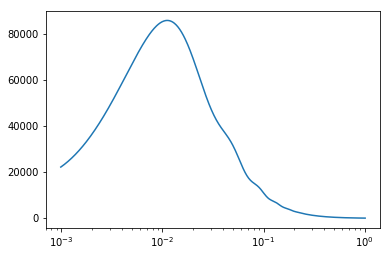

In [9]:
plt.semilogx(k, get_Pk(1,'n=-4', 'bidm+b+cdm'))

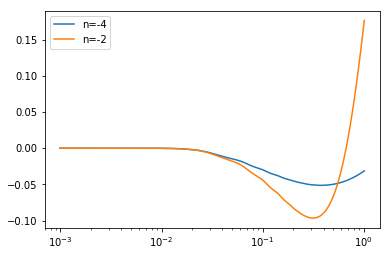

In [9]:
for M in models:
    if M != 'ref':
        plt.semilogx(k,(get_Pk(1,M,'bidm+b+cdm')-get_Pk(1,'ref','b+cdm'))/get_Pk(1,M,'bidm+b+cdm'), label=M)
        
plt.legend()

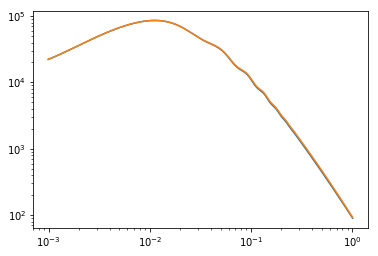

In [11]:
plt.loglog(k, get_Pk(1,'n=-4', 'bidm+b+cdm'))
plt.loglog(k, get_Pk(1,'ref', 'b+cdm'))